In [34]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
import math

import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import tokenize_re, punct, TextMetrics, load_ngrams, build_ngrams
from pygents.plot import plot_dict
from pygents.util import dictcount, dict_compress_with_loss, dictdict_div_dict, dictdict_mul_dictdict

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

In [35]:
def build_all_ngrams(tokens,ngram_max,ngram_min=1):
    all_ngrams = []
    for n in range(ngram_min, ngram_max + 1):
        ngrams = build_ngrams(tokens, n)
        all_ngrams.append(ngrams)
    return all_ngrams

assert(build_all_ngrams([1,2,3],3)==[[(1,), (2,), (3,)], [(1, 2), (2, 3)], [(1, 2, 3)]])
assert(build_all_ngrams([1,2,3],3,2)==[[(1, 2), (2, 3)], [(1, 2, 3)]])

In [62]:
def tuple_find(self,pattern):
    pat_len = len(pattern)
    if pattern[0] in self:
        index = self.index(pattern[0])
        if len(pattern) == 1:
            return index
        if (len(self) - index) >= pat_len:
            if pattern == self[index:index + pat_len]:
                return index
    return -1

assert(tuple_find((1,2),(1,))==0)
assert(tuple_find((1,2),(2,))==1)
assert(tuple_find((1,2),(1,2))==0)
assert(tuple_find((1,2),(3,))==-1)
assert(tuple_find((1,2,3),(1,2))==0)
assert(tuple_find((1,2,3),(2,3))==1)
assert(tuple_find((1,2,3),(2,3,4))==-1)

def tuple_fix(self,pattern,index):
    pat_len = len(pattern)
    if self == pattern:
        return self
    if index == 0:
        return (pattern,) + self[pat_len:]
    if (len(self) - index) == pat_len:
        return self[:index] + (pattern,)
    return self[:index] + (pattern,) + self[index + pat_len:]
        
        
assert(tuple_fix((1,2,3,4),(1,2),0)==((1,2),3,4))
assert(tuple_fix((1,2,3,4),(3,4),2)==(1,2,(3,4)))
assert(tuple_fix((1,2,3,4),(2,3),1)==(1,(2,3),4))


def setcount(s,i):
    if not i in s:
        s.add(i)
                    
def hpattern_size(hpattern,counter=setcount,dictionary=None):
    """ evaluate size of hierarchical tuple/set/dict/list-based pattern, return overall number of positions plus dictionary"""
    if dictionary is None:
        dictionary = set() if counter == setcount else {} # counter == dictcount
    positions_cnt = 0
    for hitem in hpattern:
        positions_cnt += 1
        if not hitem in dictionary:
            if type(hitem) in (tuple,list,set,dict):
                positions_cnt += hpattern_size(hitem,counter,dictionary)[1]
        counter(dictionary,hitem)
    size = positions_cnt + len(dictionary)
    return size, positions_cnt, dictionary

assert(hpattern_size((1,2,2))==(5, 3, {1, 2}))
assert(hpattern_size((1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2))==(18, 16, {1, 2})) # non-normalized input
assert(hpattern_size(((1,2,1,2,1,2,1,2),(1,2,1,2,1,2,1,2)))==(13, 10, {1, 2, (1, 2, 1, 2, 1, 2, 1, 2)})) # well-normalized model
assert(hpattern_size(((1,2,1,2),(1,2,1,2),(1,2,1,2),(1,2,1,2)))==(11, 8, {(1, 2, 1, 2), 1, 2})) # best-normalized model
assert(hpattern_size((((1,2),(1,2)),((1,2),(1,2)),((1,2),(1,2)),((1,2),(1,2))))==(12,8,{((1,2),(1,2)),(1,2),1,2})) # semi-best-normalized model!?
assert(hpattern_size(((1,2),(1,2),(1,2),(1,2),(1,2),(1,2),(1,2),(1,2)))==(13, 10, {1, 2, (1, 2)})) # well-normalized model
assert(hpattern_size((1,2,3,4,1,2,3,5,1,2,4,6,1,2,4,7))==(23, 16, {1, 2, 3, 4, 5, 6, 7})) # non-normalized input 
assert(hpattern_size(((1,2),3,4,(1,2),3,5,(1,2),4,6,(1,2),4,7))==(22, 14, {1, 2, 3, (1, 2), 4, 5, 6, 7})) # well-normalized model
assert(hpattern_size(((1,2,3),4,(1,2,3),5,(1,2,4),6,(1,2,4),7))==(23, 14, {1, 2, 3, 4, 5, 6, 7, (1, 2, 3), (1, 2, 4)})) # alt-normalized model
assert(hpattern_size((((1,2),3),4,((1,2),3),5,((1,2),4),6,((1,2),4),7))==(24, 14, {1, 2, 3, (1, 2), 4, 5, 6, 7, ((1, 2), 3), ((1, 2), 4)})) # over-normalized model



In [37]:
lm = language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/')
lm

{'All-or-nothing_thinking': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//All-or-nothing_thinking.txt',
 'Fortune-telling': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Fortune-telling.txt',
 'Mental_filter': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Mental_filter.txt',
 'Overgeneralization': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Overgeneralization.txt',
 'Distortion': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Distortion.txt',
 'Labeling': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Labeling.txt',
 'Mind_Reading': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Mind_Reading.txt',
 'Personalization': './data/models/distortions/split_combined/multiclass_view_cleaned/joint//Personalization.txt',
 'Emotional_Reasoning': './data/models/distortions/split_combined/multiclass_view_cleaned/jo

In [38]:
tm = TextMetrics(lm,encoding="utf-8",metric_logarithmic=True,debug=False)
tm.metrics

{'All-or-nothing_thinking': {('a', 'decision'),
  ('a', 'decision', 'and'),
  ('a', 'decision', 'and', 'that'),
  ('a', 'given'),
  ('a', 'given', 'issue'),
  ('a', 'given', 'issue', 'way'),
  ('a', 'week', 'ago', 'and'),
  ('about', 'a', 'given'),
  ('about', 'a', 'given', 'issue'),
  ('about', 'it', 'and', 'everything'),
  ('ago', 'and', 'now'),
  ('ago', 'and', 'now', 'i'),
  ('all', 'solved'),
  ('all', 'solved', 'and'),
  ('all', 'solved', 'and', 'i'),
  ('am', 'free'),
  ('am', 'free', 'or'),
  ('am', 'free', 'or', 'happy'),
  ('and', 'everything', 'i'),
  ('and', 'everything', 'i', 'just'),
  ('and', 'i', 'do', 'that'),
  ('and', 'i', 'know', 'it'),
  ('and', 'it’s', 'as'),
  ('and', 'it’s', 'as', 'if'),
  ('and', 'now', 'i', 'have'),
  ('and', 'that', 'problem'),
  ('and', 'that', 'problem', 'is'),
  ('because', 'im'),
  ('but', 'i', 'haven’t'),
  ('but', 'when', 'i', 'got'),
  ('can’t', 'focus'),
  ('can’t', 'focus', 'on'),
  ('can’t', 'stop', 'it'),
  ('can’t', 'stop', 'it', 

In [39]:
for m in tm.metrics:
    print(len(tm.metrics[m]),m)

190 All-or-nothing_thinking
235 Fortune-telling
75 Mental_filter
164 Overgeneralization
86176 Distortion
124 Labeling
276 Mind_Reading
198 Personalization
150 Emotional_Reasoning
183 Magnification
70 Should_statements


In [40]:
#left->right
#category = 'Labeling'
category = 'All-or-nothing_thinking'
#l = list(tm.metrics['Distortion'])
l = list(tm.metrics[category])
#l = list(tm.metrics['Mental_filter'])
l.sort()
l

[('a', 'decision'),
 ('a', 'decision', 'and'),
 ('a', 'decision', 'and', 'that'),
 ('a', 'given'),
 ('a', 'given', 'issue'),
 ('a', 'given', 'issue', 'way'),
 ('a', 'week', 'ago', 'and'),
 ('about', 'a', 'given'),
 ('about', 'a', 'given', 'issue'),
 ('about', 'it', 'and', 'everything'),
 ('ago', 'and', 'now'),
 ('ago', 'and', 'now', 'i'),
 ('all', 'solved'),
 ('all', 'solved', 'and'),
 ('all', 'solved', 'and', 'i'),
 ('am', 'free'),
 ('am', 'free', 'or'),
 ('am', 'free', 'or', 'happy'),
 ('and', 'everything', 'i'),
 ('and', 'everything', 'i', 'just'),
 ('and', 'i', 'do', 'that'),
 ('and', 'i', 'know', 'it'),
 ('and', 'it’s', 'as'),
 ('and', 'it’s', 'as', 'if'),
 ('and', 'now', 'i', 'have'),
 ('and', 'that', 'problem'),
 ('and', 'that', 'problem', 'is'),
 ('because', 'im'),
 ('but', 'i', 'haven’t'),
 ('but', 'when', 'i', 'got'),
 ('can’t', 'focus'),
 ('can’t', 'focus', 'on'),
 ('can’t', 'stop', 'it'),
 ('can’t', 'stop', 'it', 'and'),
 ('day', 'is'),
 ('decision', 'and'),
 ('decision', '

In [41]:
#right->left
r = [tuple(reversed(x)) for x in l]
r.sort()
r

[('a', 'about', 'think', 'to'),
 ('a', 'been', 'it’s'),
 ('a', 'made', 'have'),
 ('a', 'made', 'have', 'i'),
 ('a', 'trouble'),
 ('a', 'trouble', 'some'),
 ('a', 'trouble', 'some', 'had'),
 ('about', 'think', 'to', 'is'),
 ('about', 'think', 'to', 'myself'),
 ('ago', 'week', 'a', 'trouble'),
 ('all', 'is', 'problem'),
 ('all', 'is', 'problem', 'that'),
 ('am', 'i', 'when', 'however'),
 ('and', 'ago', 'week'),
 ('and', 'ago', 'week', 'a'),
 ('and', 'angry', 'i’m'),
 ('and', 'decision'),
 ('and', 'decision', 'a'),
 ('and', 'decision', 'a', 'made'),
 ('and', 'it', 'about', 'think'),
 ('and', 'it', 'stop'),
 ('and', 'it', 'stop', 'can’t'),
 ('and', 'solved'),
 ('and', 'solved', 'all'),
 ('and', 'solved', 'all', 'is'),
 ('are', 'why'),
 ('as', 'it’s'),
 ('as', 'it’s', 'and'),
 ('because', 'things'),
 ('but', 'side'),
 ('can’t', 'just', 'i', 'everything'),
 ('changed', 'everything'),
 ('death', 'his'),
 ('decision', 'a'),
 ('decision', 'a', 'made'),
 ('decision', 'a', 'made', 'have'),
 ('do'

In [42]:
#TODO count for compression
N_max = max([len(x) for x in l]) - 1
N_max

3

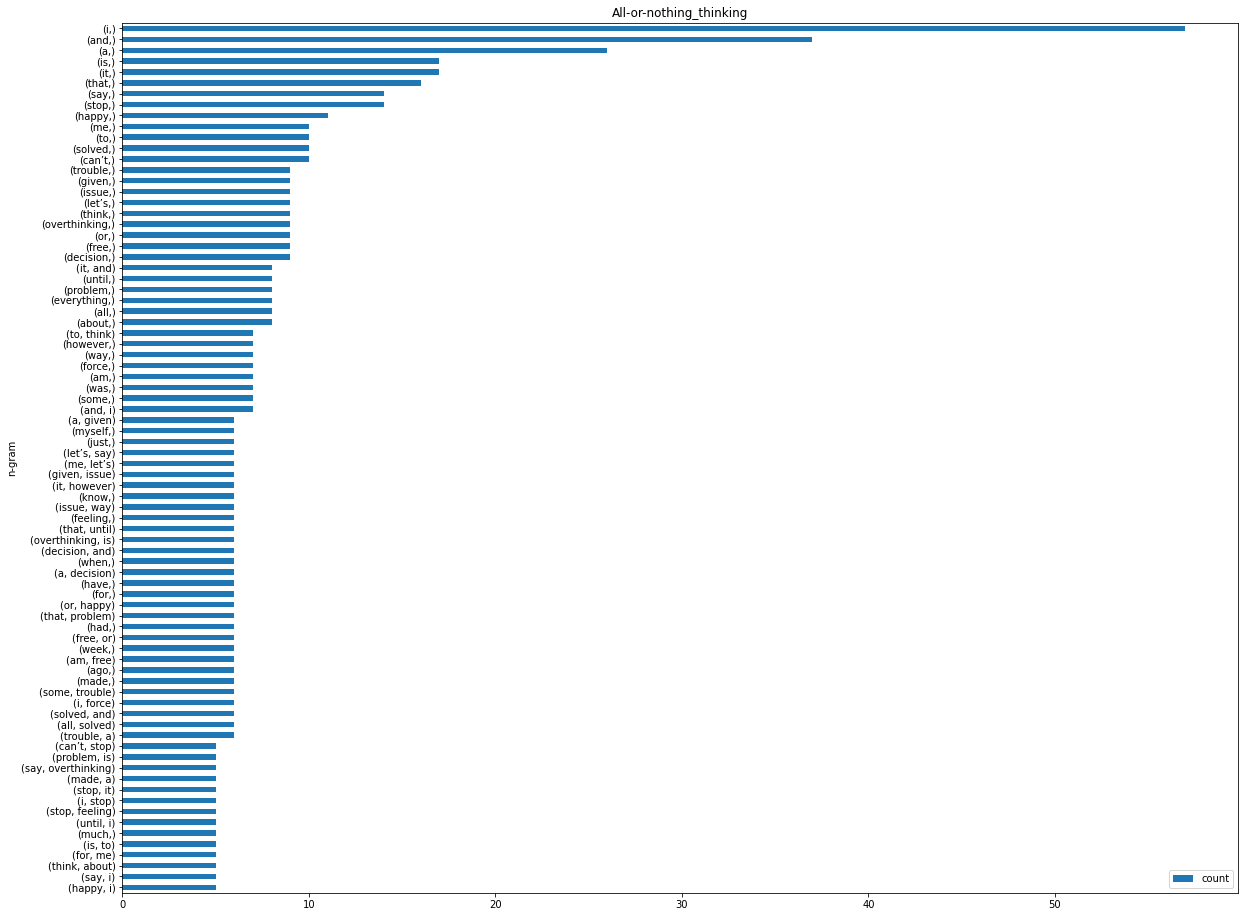

In [43]:
ng_cnt = {}
for g in l:
    ngs = build_all_ngrams(g,N_max)
    for ng in ngs:
        dictcount(ng_cnt,ng)
plot_dict(
    ng_cnt,
    labels="n-gram",
    values="count",
    title=category,
    head=80                # Top 20 words
)

In [123]:
def hpattern_compact(l,n_max=4,min_cnt=2,debug=False,ng_cnt=None):
    if ng_cnt is None:
        ng_cnt = {}
    min_cnt = 2
    size_old = size_0
    l_old = l
    #loops = 0
    while (True):
        #count frequencies
        ng_cnt.clear()
        for g in l_old:
            ngs = build_all_ngrams(g,n_max,2)
            for ng in ngs:
                dictcount(ng_cnt,ng)
        #found the top 
        top_cnt = 0
        top_ngs = set()
        for ng in ng_cnt:
            cnt = ng_cnt[ng]
            if cnt > top_cnt:
                top_ngs.clear()
                top_ngs.add(ng)
                top_cnt = cnt
            elif cnt == top_cnt:
                top_ngs.add(ng)
        if top_cnt < min_cnt:
            break
        # replace
        l_new = []
        for ng in l_old:
            new_ng = ng
            for top_ng in top_ngs:
                if len(new_ng) > len(top_ng): # if inclusion is possible
                    while (True):
                        index = tuple_find(new_ng,top_ng)
                        if index >= 0:
                            new_ng = tuple_fix(new_ng,top_ng,index)
                            #print(new_ng)
                        else:
                            break
            l_new.append(new_ng)
        size_new = hpattern_size(l_new)[0]
        if debug:
            print(top_cnt,len(top_ngs),'=>',size_new,top_ngs)
        #loops += 1
        #if loops < 20:
        if size_new < size_old:
            l_old = l_new
            size_old = size_new
        else:
            break
    return l_old

print(hpattern_compact([(1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2)]))
print(hpattern_compact([(1,2,3,4,1,2,3,5,1,2,4,6,1,2,4,7)]))
print(hpattern_compact([(1,2,3,4,1,2,3,5,1,2,3,6,1,2,3,7)]))

[(((1, 2), (1, 2)), ((1, 2), (1, 2)), ((1, 2), (1, 2)), ((1, 2), (1, 2)))]
[((1, 2), 3, 4, (1, 2), 3, 5, (1, 2), 4, 6, (1, 2), 4, 7)]
[((1, (2, 3)), 4, (1, (2, 3)), 5, (1, (2, 3)), 6, (1, (2, 3)), 7)]


In [124]:
#original size
size_0 = hpattern_size(l)[0]

l_comp = hpattern_compact(l,min_cnt=2,debug=True)

print(size_0,hpattern_size(l_comp)[0]) # collect the best results


8 1 => 1074 {('it', 'and')}
7 1 => 1070 {('to', 'think')}
6 19 => 997 {('overthinking', 'is'), ('issue', 'way'), ('i', 'force'), ('am', 'free'), ('that', 'problem'), ('it', 'however'), ('or', 'happy'), ('a', 'given'), ('given', 'issue'), ('that', 'until'), ('solved', 'and'), ('trouble', 'a'), ('some', 'trouble'), ('me', 'let’s'), ('free', 'or'), ('a', 'decision'), ('decision', 'and'), ('let’s', 'say'), ('all', 'solved')}
5 5 => 988 {('can’t', 'stop'), ('everything', 'i'), ('stop', 'feeling'), ('i', 'stop'), ('ago', 'and')}
4 7 => 977 {('have', 'made'), ('when', 'i'), ('it’s', 'as'), ('much', 'for'), ('i', 'had'), ('i', 'was'), ('can’t', 'focus')}
3 26 => 948 {('know', ('it', 'however')), ('all', ('solved', 'and')), (('everything', 'i'), 'just'), ('some', ('trouble', 'a')), ('i', ('stop', 'feeling')), ('do', ('that', 'until')), ('i', 'do'), (('i', 'force'), 'myself'), (('a', 'decision'), 'and'), (('that', 'problem'), 'is'), ('myself', ('to', 'think')), (('trouble', 'a'), 'week'), (('iss

In [125]:
l_comp

[('a', 'decision'),
 (('a', 'decision'), 'and'),
 ((('a', 'decision'), 'and'), 'that'),
 ('a', 'given'),
 (('a', 'given'), 'issue'),
 (('a', 'given'), ('issue', 'way')),
 ('a', ('week', ('ago', 'and'))),
 ('about', ('a', 'given')),
 (('about', ('a', 'given')), 'issue'),
 ('about', (('it', 'and'), 'everything')),
 (('ago', 'and'), 'now'),
 (('ago', 'and'), ('now', 'i')),
 ('all', 'solved'),
 ('all', ('solved', 'and')),
 (('all', ('solved', 'and')), 'i'),
 ('am', 'free'),
 (('am', 'free'), 'or'),
 (('am', 'free'), ('or', 'happy')),
 ('and', ('everything', 'i')),
 ('and', (('everything', 'i'), 'just')),
 ('and', ('i', 'do'), 'that'),
 ('and', ('i', 'know'), 'it'),
 ('and', ('it’s', 'as')),
 ('and', (('it’s', 'as'), 'if')),
 ('and', ('now', 'i'), 'have'),
 ('and', ('that', 'problem')),
 ('and', (('that', 'problem'), 'is')),
 ('because', 'im'),
 ('but', 'i', 'haven’t'),
 ('but', ('when', 'i'), 'got'),
 ('can’t', 'focus'),
 (('can’t', 'focus'), 'on'),
 (('can’t', 'stop'), 'it'),
 (('can’t', 

## Explore corpus-wise patterns

In [126]:
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 


Path to dataset files: /Users/akolonin/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


In [127]:
df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)
df1

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


In [128]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [129]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [130]:
texts = df3['Patient Question'].tolist()
len(texts)

6057

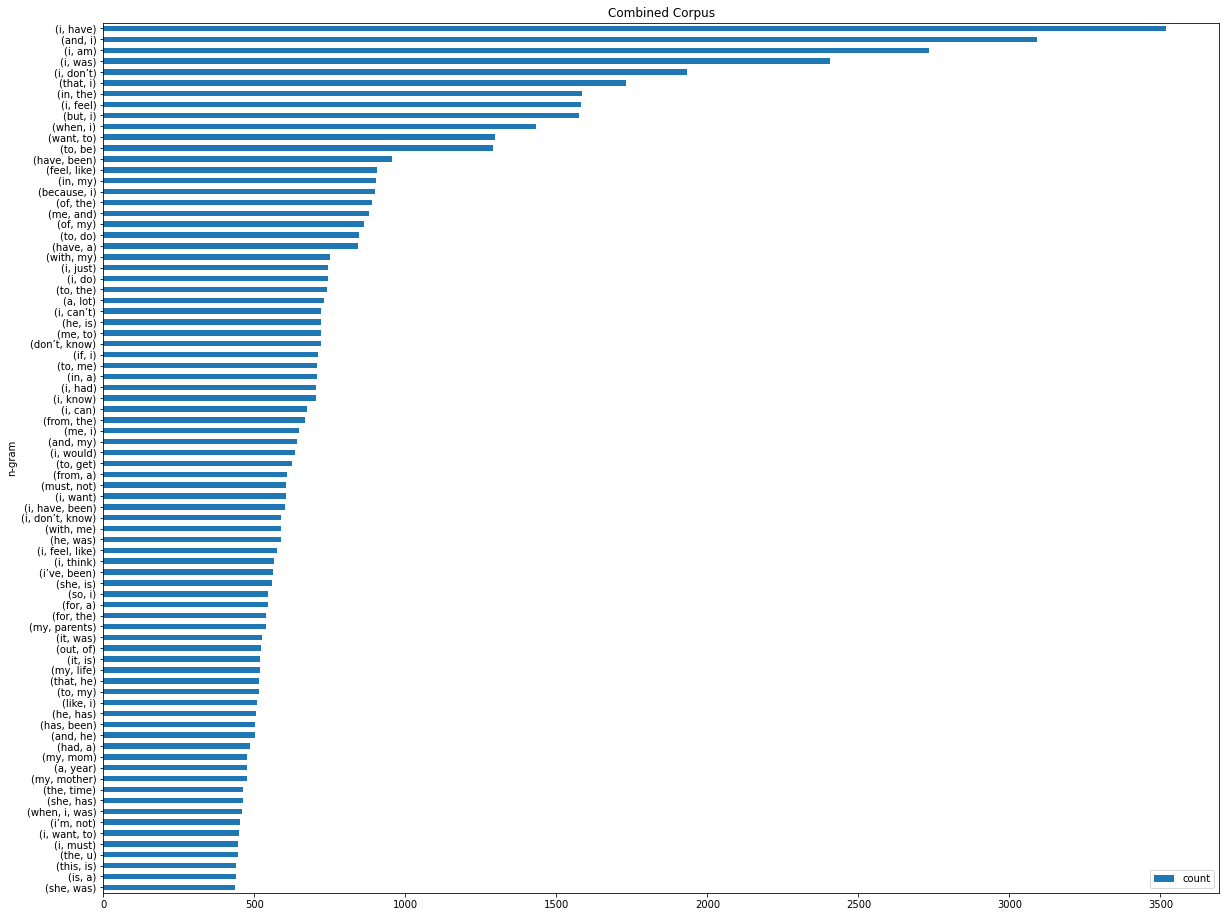

In [131]:
N_max = 4
ng_cnt = {}
texttoks = []
for text in texts:
    tokens = [t for t in tokenize_re(text) if not (t in punct or t.isnumeric())]
    texttoks.append(tuple(tokens))
    ngs = build_all_ngrams(tokens,N_max,2)
    for ng in ngs:
        dictcount(ng_cnt,ng)
plot_dict(ng_cnt, labels="n-gram", values="count", title="Combined Corpus", head=80)

In [132]:
texttoks[:5]

[("i'm", 'such', 'a', 'failure', 'i', 'never', 'do', 'anything', 'right'),
 ('nobody', 'likes', 'me', 'because', "i'm", 'not', 'interesting'),
 ('i',
  "can't",
  'try',
  'new',
  'things',
  'because',
  "i'll",
  'just',
  'mess',
  'them',
  'up'),
 ('my',
  'boss',
  "didn't",
  'say',
  'good',
  'morning',
  'she',
  'must',
  'be',
  'angry',
  'with',
  'me'),
 ('my',
  'friend',
  "didn't",
  'invite',
  'me',
  'to',
  'the',
  'party',
  'i',
  'must',
  'be',
  'a',
  'terrible',
  'friend')]

In [134]:
#original size
size_0 = hpattern_size(texttoks)[0]

ng_cnt = {}
t_comp = hpattern_compact(texttoks,min_cnt=2,debug=True,ng_cnt=ng_cnt)

print(size_0,hpattern_size(t_comp)[0]) # collect the best results


3519 1 => 551654 {('i', 'have')}
2952 1 => 550912 {('and', 'i')}
2676 1 => 550285 {('i', 'am')}
2450 1 => 550102 {('i', 'have')}
2370 1 => 549540 {('i', 'was')}
2225 1 => 549501 {('i', 'have')}
2175 1 => 549501 {('i', 'have')}
552513 549501


In [135]:
t_comp[:5]

[("i'm", 'such', 'a', 'failure', 'i', 'never', 'do', 'anything', 'right'),
 ('nobody', 'likes', 'me', 'because', "i'm", 'not', 'interesting'),
 ('i',
  "can't",
  'try',
  'new',
  'things',
  'because',
  "i'll",
  'just',
  'mess',
  'them',
  'up'),
 ('my',
  'boss',
  "didn't",
  'say',
  'good',
  'morning',
  'she',
  'must',
  'be',
  'angry',
  'with',
  'me'),
 ('my',
  'friend',
  "didn't",
  'invite',
  'me',
  'to',
  'the',
  'party',
  'i',
  'must',
  'be',
  'a',
  'terrible',
  'friend')]

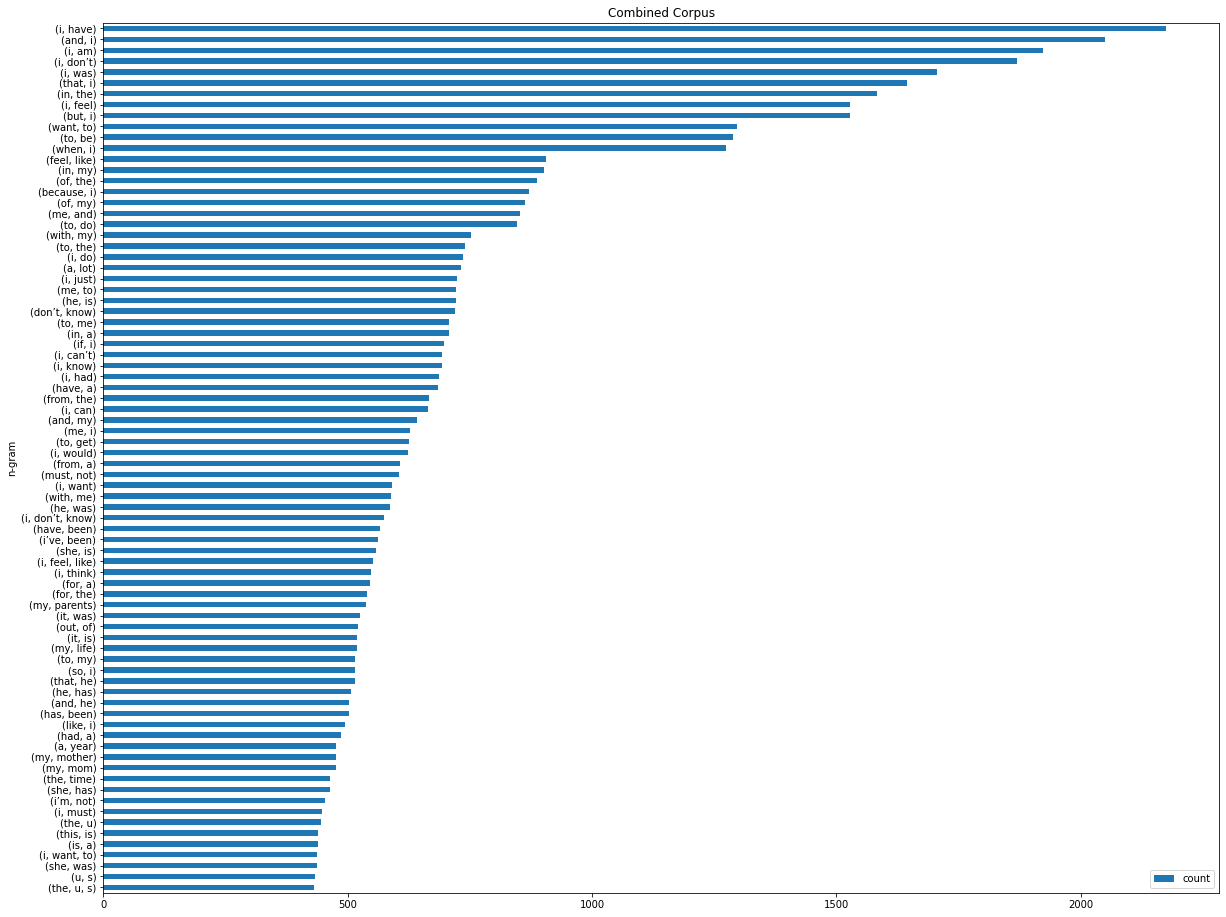

In [136]:
plot_dict(ng_cnt, labels="n-gram", values="count", title="Combined Corpus", head=80)

In [ ]:
# FIX BUG!? why i have repeated !!??

In [21]:
# todo replace self-replacements

In [22]:
# Compute the size of model
# Compute all frequences
# Replace most frequent item everywhere
# Compute the size of model agin, if it is not decresed - stop, if it is decreased go to the beginning and repeat

# Model - compressed data
# Intepretable model - compressed model